# Predictive Maintenance with Azure Dataset

## Project imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

## Data Imports

Needs pre-processing.ipynb to be run first

In [3]:
def read(name: str, parse_dates: list[str] | None = ["datetime"]) -> pd.DataFrame:
    path = "data/"
    ext = ".csv"
    file = path + name + ext
    return pd.read_csv(file, parse_dates=parse_dates, na_values="NaN")

VARIABLES = ["volt", "rotate", "pressure", "vibration"]
DATA = read("raw_data").dropna(subset=VARIABLES)
normal_behavior_data = read("preprocessing/expected_behavior")
abnormal_data = read("preprocessing/failures_only")

## Full dataset clustering

### K-means

#### Pre-processing

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

STATE = 42

independent_data = DATA.drop(
    columns=["datetime", "machineID", "errorID", "failure", "comp"]
)


numeric_features = ["volt", "rotate", "pressure", "vibration", "age"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["model"]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessed_data = preprocessor.fit_transform(independent_data)

#### Identifying the optimal number of clusters

- Elbow method

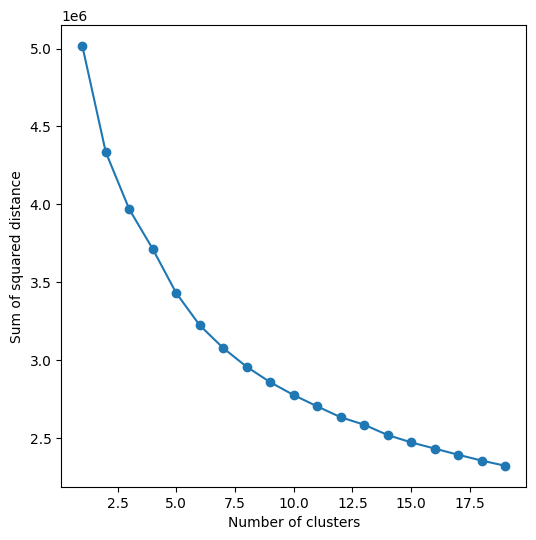

In [5]:
from sklearn.cluster import KMeans

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=STATE)
    km.fit(preprocessed_data)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.show()

- Silhouette method

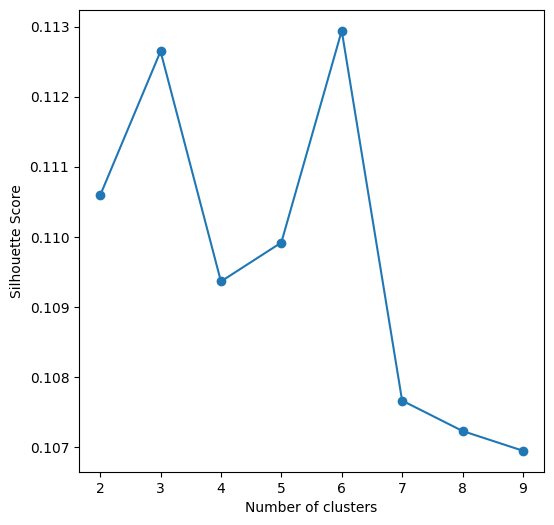

In [6]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
list_k = list(range(2, 10)) 
sample_size = int(0.1 * len(preprocessed_data))

for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, random_state=STATE)
    km.fit(preprocessed_data)
    sample_indices = np.random.choice(
        np.arange(len(preprocessed_data)), size=sample_size, replace=False
    )
    sample_data = preprocessed_data[sample_indices]

    score = silhouette_score(sample_data, km.labels_[sample_indices])
    silhouette_scores.append(score)

plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_scores, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

Considering the results from the two methods, the optimal number of clusters appears to be 6.

#### Comparing with known labels

- Mean values for features in each cluster

In [9]:
n_clusters= 6
kmeans = KMeans(n_clusters=n_clusters, random_state=STATE)
kmeans.fit(preprocessed_data)
DATA["cluster"] = kmeans.labels_

for feature in ["volt", "rotate", "pressure", "vibration", "age"]:
    print(DATA.groupby("cluster")[feature].mean())

cluster
0    169.578992
1    188.988687
2    158.902463
3    170.415023
4    170.359270
5    168.703903
Name: volt, dtype: float64
cluster
0    381.480938
1    449.867883
2    450.824190
3    450.584839
4    455.004565
5    486.962392
Name: rotate, dtype: float64
cluster
0     98.049591
1     99.094746
2     98.843813
3    118.364836
4     98.734935
5     96.412468
Name: pressure, dtype: float64
cluster
0    38.913833
1    39.828138
2    39.860750
3    39.777074
4    47.723651
5    37.131409
Name: vibration, dtype: float64
cluster
0    14.466316
1     6.602471
2     4.763422
3    12.765728
4    14.303334
5    15.581407
Name: age, dtype: float64


- Distribution of failures in each cluster

In [10]:
print(DATA.groupby("cluster")["failure"].value_counts(dropna=False))

cluster  failure
0        NaN        147442
         comp2         193
         comp1          35
         comp4          20
         comp3           8
1        NaN        141967
         comp1         123
         comp2          50
         comp3          10
         comp4           3
2        NaN        164899
         comp2          55
         comp1          13
         comp3           6
3        NaN        116386
         comp3         159
         comp2          38
         comp1          31
         comp4          28
4        NaN        136591
         comp4         197
         comp1          48
         comp2          41
         comp3           5
5        NaN        168802
         comp1          41
         comp2           9
         comp4           7
         comp3           2
Name: count, dtype: int64


- Occurrences for other labels in each cluster

In [11]:
for label in ["errorID", "comp", "model"]:
    print(DATA.groupby("cluster")[label].value_counts(dropna=False))

cluster  errorID
0        NaN        146894
         error2        256
         error3        252
         error1        145
         error4         98
         error5         53
1        NaN        141496
         error1        244
         error2        143
         error3        135
         error4        101
         error5         34
2        NaN        164349
         error1        193
         error2        150
         error3        125
         error4        125
         error5         31
3        NaN        116060
         error4        184
         error1        132
         error2        126
         error3         99
         error5         41
4        NaN        136217
         error5        158
         error1        147
         error2        147
         error3        113
         error4        100
5        NaN        168269
         error2        166
         error1        152
         error4        120
         error3        114
         error5         40
Name: count

#### Calculating the percentages of labels in each cluster

In [12]:
# Create a new column 'has_label' that is 1 if the row has a label and 0 otherwise
for label in ["errorID", "failure", "comp"]:
    DATA[label + "_has_label"] = ~DATA[label].isna()

# Calculate the percentage of rows with no label in each cluster
for label in ["errorID", "failure", "comp"]:
    print(DATA.groupby("cluster")[label + "_has_label"].mean() * 100)

cluster
0    0.544354
1    0.462178
2    0.378244
3    0.498963
4    0.485820
5    0.350584
Name: errorID_has_label, dtype: float64
cluster
0    0.173327
1    0.130845
2    0.044856
3    0.219475
4    0.212592
5    0.034940
Name: failure_has_label, dtype: float64
cluster
0    0.354778
1    0.372838
2    0.283077
3    0.431234
4    0.398884
5    0.235697
Name: comp_has_label, dtype: float64


In [13]:
# Create a new column 'total_has_label' that is 1 if the row has at least one label and 0 otherwise
DATA["total_has_label"] = (
    DATA[["errorID_has_label", "failure_has_label", "comp_has_label"]].sum(axis=1) > 0
)

# Calculate the percentage of rows with at least one label in each cluster
print(DATA.groupby("cluster")["total_has_label"].mean() * 100)

cluster
0    0.899809
1    0.835719
2    0.661926
3    0.932769
4    0.883973
5    0.586281
Name: total_has_label, dtype: float64
